# Analyse de la structure de la consommation par quintile de revenus et but de consommation COICOP

Consumption per quintile : https://ec.europa.eu/eurostat/databrowser/view/hbs_str_t223__custom_16988313/default/table?lang=en 


Emissions by NACE Rev. 2 activity : https://ec.europa.eu/eurostat/databrowser/view/ENV_AC_AINAH_R2__custom_18029817/default/table

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import des données

In [3]:
data = pd.read_csv('./data/hbs_str_t223__custom_18015954_linear_2_0.csv')

In [4]:
data.TIME_PERIOD.unique()

array([1994, 1999, 2005, 2010, 2015, 2020, 1988])

In [5]:
data['Classification of individual consumption by purpose (COICOP)'].unique()

array(['Food and non-alcoholic beverages',
       'Alcoholic beverages, tobacco and narcotics',
       'Clothing and footwear',
       'Housing, water, electricity, gas and other fuels',
       'Electricity, gas and other fuels', 'Electricity', 'Gas',
       'Liquid fuels', 'Solid fuels', 'Heat energy',
       'Furnishings, household equipment and routine household maintenance',
       'Health', 'Transport', 'Operation of personal transport equipment',
       'Fuels and lubricants for personal transport equipment',
       'Transport services', 'Communications', 'Recreation and culture',
       'Education', 'Restaurants and hotels',
       'Miscellaneous goods and services'], dtype=object)

In [6]:
df = data[
    (data['TIME_PERIOD']==2020)
    &(data['Classification of individual consumption by purpose (COICOP)'].isin(['Electricity, gas and other fuels', 'Fuels and lubricants for personal transport equipment']))
    &(data['OBS_FLAG'].isna())
    ]
df['Classification of individual consumption by purpose (COICOP)'].unique()

array(['Electricity, gas and other fuels'], dtype=object)

In [7]:
df = df[~df['geo'].isin(['EA','EU15','EU27_2020', 'EU27_2007','EU27_2020','EU25', 'EA12', 'EA13', 'EA17', 'EA18', 'EA20', 'EEA28', 'EEA30_2007','EFTA', 'TR','RS'])]
df = df[df['quantile'].isin(['QUINTILE1', 'QUINTILE5'])]
country_list = df.geo.unique()
country_list

array(['AT', 'BE', 'BG', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'HR', 'HU',
       'IE', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'SI', 'SK'],
      dtype=object)

In [8]:
df['Geopolitical entity (reporting)'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Germany', 'Denmark', 'Estonia',
       'Greece', 'Spain', 'Finland', 'Croatia', 'Hungary', 'Ireland',
       'Lithuania', 'Luxembourg', 'Latvia', 'Montenegro', 'Netherlands',
       'Norway', 'Poland', 'Slovenia', 'Slovakia'], dtype=object)

Différencier par niveau de pollution par Household

In [9]:
df.groupby(['quantile','Classification of individual consumption by purpose (COICOP)'])['OBS_VALUE'].mean()

quantile   Classification of individual consumption by purpose (COICOP)
QUINTILE1  Electricity, gas and other fuels                                88.380952
QUINTILE5  Electricity, gas and other fuels                                50.000000
Name: OBS_VALUE, dtype: float64

In [10]:
emissions = pd.read_csv('./data/env_ac_ainah_r2__custom_18029817_linear_2_0.csv')

In [11]:
df_emissions = emissions[
    (emissions.TIME_PERIOD==2020)
    &(emissions['nace_r2']=='HH_HEAT')
    &(emissions['unit']=='KG_HAB')
    &(~emissions['geo'].isin(['CH', 'EU27_2020','IS','LU']))
    &(emissions['OBS_FLAG'].isna())
    ]

df_emissions['Geopolitical entity (reporting)'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark', 'Estonia', 'Greece', 'Spain', 'Finland', 'France',
       'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Latvia',
       'Malta', 'Norway', 'Poland', 'Portugal', 'Romania', 'Sweden',
       'Slovenia', 'Slovakia'], dtype=object)

In [12]:
q1_emissions = df_emissions['OBS_VALUE'].quantile(0.25)
q3_emissions = df_emissions['OBS_VALUE'].quantile(0.75)
mean_emissions = df_emissions['OBS_VALUE'].quantile(0.5)

countries_q4 = df_emissions[df_emissions['OBS_VALUE']>=q3_emissions]['Geopolitical entity (reporting)']
countries_q3 = df_emissions[
    (df_emissions['OBS_VALUE']<=q3_emissions)
    &
    (df_emissions['OBS_VALUE']>=mean_emissions)
    ]['Geopolitical entity (reporting)']
countries_q2 = df_emissions[
    (df_emissions['OBS_VALUE']<=mean_emissions)
    &(df_emissions['OBS_VALUE']>=q1_emissions)
    ]['Geopolitical entity (reporting)']
countries_q1 = df_emissions[df_emissions['OBS_VALUE']<=q1_emissions]['Geopolitical entity (reporting)']

countries_mid = df_emissions[(df_emissions['OBS_VALUE']<mean_emissions)&((df_emissions['OBS_VALUE']>q1_emissions))]['Geopolitical entity (reporting)']

In [13]:
countries_q1

36410    Bulgaria
36493     Estonia
36549     Finland
36689       Malta
36717      Norway
36745    Portugal
36773      Sweden
Name: Geopolitical entity (reporting), dtype: object

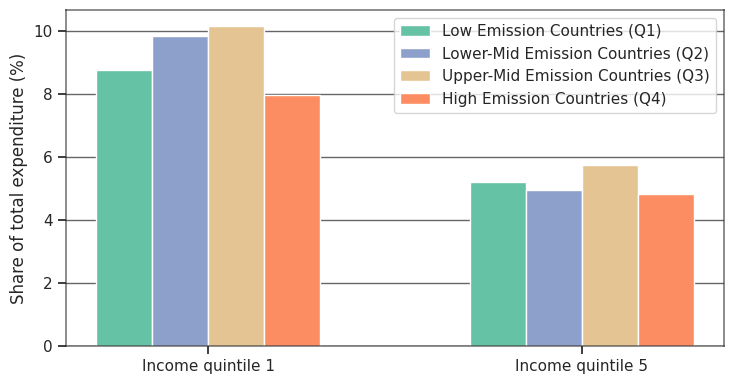

In [14]:
sns.set_theme(style="ticks")

def compute_group_means(group_countries):
    return df[df['Geopolitical entity (reporting)'].isin(group_countries)].groupby('quantile')['OBS_VALUE'].mean()/10

mean_all = df.groupby('quantile')['OBS_VALUE'].mean()/10
mean_q1 = compute_group_means(countries_q1)
mean_q2 = compute_group_means(countries_q2)
mean_q3 = compute_group_means(countries_q3)
mean_q4 = compute_group_means(countries_q4)
mean_mid = compute_group_means(countries_mid)

quintiles = ['QUINTILE1', 'QUINTILE5']
x = np.arange(len(quintiles))
bar_width = 0.15

palette = sns.color_palette("Set2", 12)

plt.figure(figsize=(7.5, 4))
plt.bar(x - 1.5*bar_width, mean_q1[quintiles], width=bar_width, label='Low Emission Countries (Q1)', color=palette[0])
plt.bar(x - 0.5*bar_width, mean_q2[quintiles], width=bar_width, label='Lower-Mid Emission Countries (Q2)', color=palette[2])
plt.bar(x + 0.5*bar_width, mean_q3[quintiles], width=bar_width, label='Upper-Mid Emission Countries (Q3)', color=palette[6])
plt.bar(x + 1.5*bar_width, mean_q4[quintiles], width=bar_width, label='High Emission Countries (Q4)', color=palette[1])

plt.xticks(x, ['Income quintile 1', 'Income quintile 5'])
plt.ylabel('Share of total expenditure (%)')

plt.grid(axis='y', linestyle='-', color='black', alpha=0.6)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_alpha(0.6)

plt.legend()
plt.tight_layout()
plt.show()

In [15]:
countries_q3

36382     Austria
36437      Cyprus
36507      Greece
36563      France
36577     Croatia
36801    Slovakia
Name: Geopolitical entity (reporting), dtype: object

# Transport fuel

In [16]:
df_transport = data[
    (data['TIME_PERIOD']==2010)
    &(data['Classification of individual consumption by purpose (COICOP)'].isin([
        'Fuels and lubricants for personal transport equipment']))
    &(data['OBS_FLAG'].isna())
    ]
df_transport['Classification of individual consumption by purpose (COICOP)'].unique()
df_transport['OBS_VALUE'] = df_transport['OBS_VALUE']/10
print(df_transport['Geopolitical entity (reporting)'].unique())
df_transport = df_transport.groupby(['quantile','Classification of individual consumption by purpose (COICOP)'])['OBS_VALUE'].mean().reset_index()
df_transport['quantile_num'] = (
    df_transport['quantile']
    .str.extract(r'(\d+)')
    .astype(int)
)

['Norway']


/tmp/ipykernel_5750/3881664719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transport['OBS_VALUE'] = df_transport['OBS_VALUE']/10


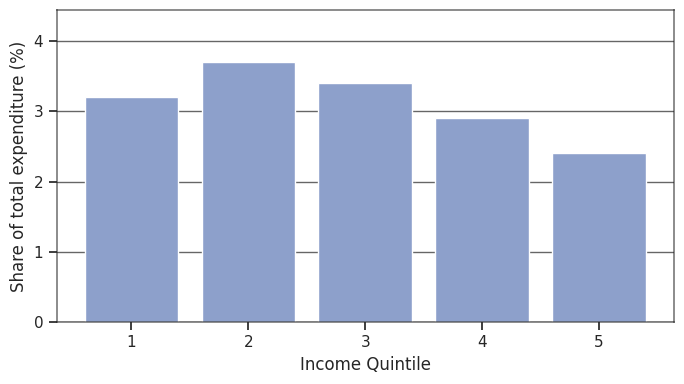

In [17]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(7, 4))
palette = sns.color_palette("Set2", 12)
ax.bar(df_transport['quantile_num'], df_transport['OBS_VALUE'], color=palette[2])

# ax.set_title("Transport Fuel")
ax.set_ylabel("Share of total expenditure (%)")
ax.set_xlabel("Income Quintile")
ax.set_ylim(0, df_transport['OBS_VALUE'].max() * 1.2)

ymax = ax.get_ylim()[1]
ax.set_yticks(np.arange(0, np.ceil(ymax), 1))
plt.grid(axis='y', linestyle='-', color='black', alpha=0.6)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_alpha(0.6)
plt.tight_layout()
plt.show()

# Energy mix

In [18]:
energy_mix = pd.read_csv('./data/nrg_bal_peh__custom_18036327_linear_2_0.csv')
energy_mix = energy_mix[energy_mix['TIME_PERIOD']==2020]
energy_mix = energy_mix[energy_mix['geo'].isin(country_list)]

In [19]:
energy_mix['Geopolitical entity (reporting)'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Germany', 'Denmark', 'Estonia',
       'Greece', 'Spain', 'Finland', 'Croatia', 'Hungary', 'Ireland',
       'Lithuania', 'Luxembourg', 'Latvia', 'Montenegro', 'Netherlands',
       'Norway', 'Poland', 'Slovenia', 'Slovakia'], dtype=object)

In [20]:
fossil = energy_mix[energy_mix['Standard international energy product classification (SIEC)'] == 'Fossil energy']
total = energy_mix[energy_mix['Standard international energy product classification (SIEC)'] == 'Total']
merged = fossil.merge(total, on=['Geopolitical entity (reporting)', 'TIME_PERIOD'], suffixes=('_fossil', '_total'))
merged['fossil_share'] = merged['OBS_VALUE_fossil'] / merged['OBS_VALUE_total']
merged['fossil_share_percent'] = merged['fossil_share'] * 100

In [21]:
q1_share = merged['fossil_share'].quantile(0.33)
q3_share = merged['fossil_share'].quantile(0.66)
mean_share = merged['fossil_share'].quantile(0.5)

countries_high_share = merged[merged['fossil_share']>q3_share]['Geopolitical entity (reporting)']
countries_low_share = merged[merged['fossil_share']<q1_share]['Geopolitical entity (reporting)']
countries_mid_share = merged[(merged['fossil_share']<q3_emissions)&((merged['fossil_share']>q1_share))]['Geopolitical entity (reporting)']

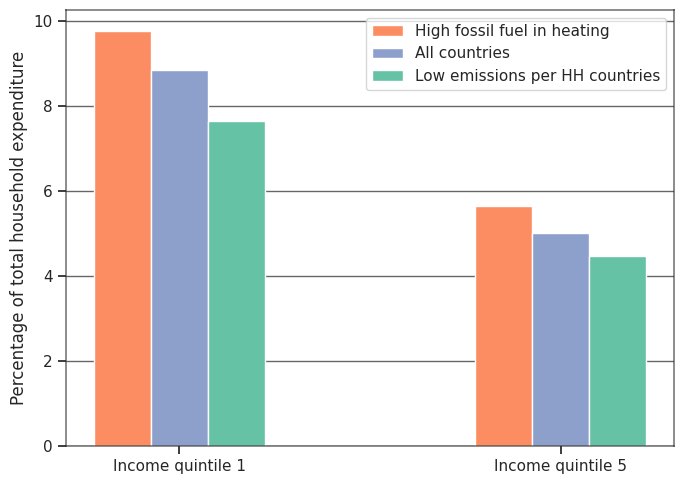

In [22]:
# Compute mean energy share by quintile and country group
def compute_group_means(group_countries):
    return df[df['Geopolitical entity (reporting)'].isin(group_countries)].groupby('quantile')['OBS_VALUE'].mean()/10

mean_all = df.groupby('quantile')['OBS_VALUE'].mean()/10
mean_low = compute_group_means(countries_low_share)
mean_high = compute_group_means(countries_high_share)
mean_mid = compute_group_means(countries_mid)

plt.figure(figsize=(7, 5))
plt.bar(x - bar_width, mean_high[quintiles], width=bar_width, label='High fossil fuel in heating', color=palette[1])
# plt.bar(x, mean_mid[quintiles], width=bar_width, label='Mid emissions per households', color=palette[2])
plt.bar(x, mean_all[quintiles], width=bar_width, label='All countries', color=palette[2])
plt.bar(x + bar_width, mean_low[quintiles], width=bar_width, label='Low emissions per HH countries', color=palette[0])

plt.xticks(x, ['Income quintile 1', 'Income quintile 5'])
plt.ylabel('Percentage of total household expenditure')
# plt.ylim(0, max(mean_all.max(), mean_low.max(), mean_high.max()) * 1.2)

plt.grid(axis='y', linestyle='-', color='black', alpha=0.6)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_alpha(0.6)  # lower alpha -> lighter frame

plt.legend()
plt.tight_layout()
plt.show()